In [3]:
from PIL import Image
import torch
from modeling.BaseModel import BaseModel
from modeling import build_model
from utilities.distributed import init_distributed
from utilities.arguments import load_opt_from_config_files
from utilities.constants import BIOMED_CLASSES

from inference_utils.inference import interactive_infer_image

In [ ]:
import huggingface_hub

HF_TOKEN = 'YOUR_HUGGINGFACE_TOKEN'

huggingface_hub.login(HF_TOKEN)

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
Your token has been saved to /home/theodorezhao/.cache/huggingface/token
Login successful


### Model Setup

In [5]:
# Build model config
opt = load_opt_from_config_files(["configs/biomedparse_inference.yaml"])
opt = init_distributed(opt)

# Load model from pretrained weights
pretrained_pth = 'hf_hub:microsoft/BiomedParse'

model = BaseModel(opt, build_model(opt)).from_pretrained(pretrained_pth).eval().cuda()
with torch.no_grad():
    model.model.sem_seg_head.predictor.lang_encoder.get_text_embeddings(BIOMED_CLASSES + ["background"], is_eval=True)

$UNUSED$ criterion.empty_weight, Ckpt Shape: torch.Size([17])


### Utility Functions

In [6]:
def plot_segmentation_masks(original_image, segmentation_masks, texts):
    ''' Plot a list of segmentation mask over an image.
    '''
    original_image = original_image[:, :, :3]
    fig, ax = plt.subplots(1, len(segmentation_masks) + 1, figsize=(10, 5))
    ax[0].imshow(original_image, cmap='gray')
    ax[0].set_title('Original Image')
    # grid off
    for a in ax:
        a.axis('off')

    for i, mask in enumerate(segmentation_masks):
        
        ax[i+1].set_title(texts[i])
        mask_temp = original_image.copy()
        mask_temp[mask > 0.5] = [255, 0, 0]
        mask_temp[mask <= 0.5] = [0, 0, 0, ]
        ax[i+1].imshow(mask_temp, alpha=0.9)
        ax[i+1].imshow(original_image, cmap='gray', alpha=0.5)
        
    
    plt.show()

In [7]:
!pip install pydicom nibabel SimpleITK

import json
import matplotlib.pyplot as plt

from inference_utils.processing_utils import read_dicom


def inference_dicom(file_path, text_prompts, is_CT, site=None):
    image = read_dicom(file_path, is_CT, site=site)
    
    pred_mask = interactive_infer_image(model, Image.fromarray(image), text_prompts)

    # Plot feature over image
    plot_segmentation_masks(image, pred_mask, text_prompts)
    
    return image, pred_mask


### CT Example

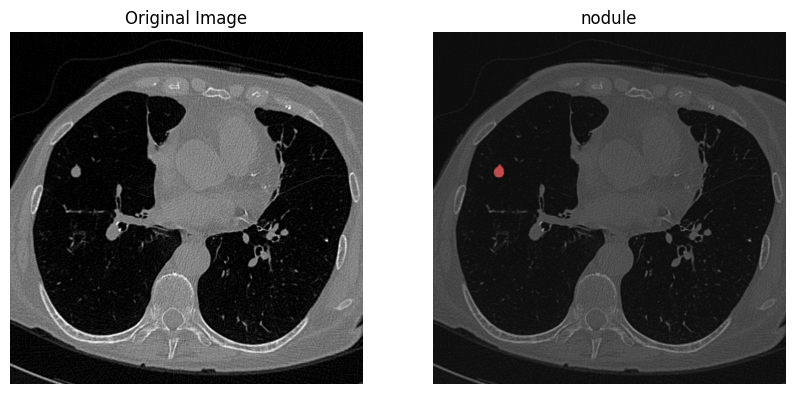

In [8]:
image_path = 'examples/CT_lung_nodule.dcm'
text_prompt = ['nodule']

image, pred_mask = inference_dicom(image_path, text_prompt, is_CT=True, site='lung')

### Check P Value

In [9]:
from inference_utils.output_processing import check_mask_stats

# P-value (adjusted) that the segmentation belongs to "nodule" in the CT-Chest class
# Lower p-value indicates it is likely the segmentation not belongs to the class. Recommended threshold is 0.05
adj_pvalue = check_mask_stats(image, pred_mask[0]*255, 'CT-Chest', 'nodule')
print(f'P-value: {adj_pvalue}')

P-value: 0.5401201055783544


### Negative example

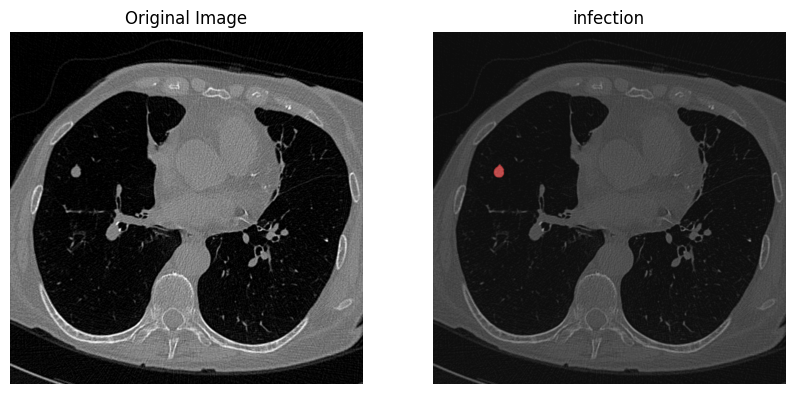

In [10]:
text_prompt = ['infection']

image, pred_mask = inference_dicom(image_path, text_prompt, is_CT=True, site='lung')

In [11]:
# P-value (adjusted) that the segmentation belongs to "nodule" in the CT-Chest class
# Lower p-value indicates it is likely the segmentation not belongs to the class. Recommend to use a threshold of 0.05
adj_pvalue = check_mask_stats(image, pred_mask[0]*255, 'CT-Chest', 'COVID-19 infection')
print(f'P-value: {adj_pvalue}')

P-value: 0.027177424862468297
